## Aeroelastic Analysis of a Typical Section

In this example, we perform a two-dimensional aeroelastic analysis for a two degree of
freedom typical section model.

![](../assets/section-drawing.svg)

The equations of motion for this model are
$$
m \left(\ddot{h}+b x_\theta \ddot{\theta} \right) + k_h h = -L \\
I_\theta \ddot{\theta} + m b x_\theta \ddot{h} + k_\theta = M
$$
where $b$ is the semichord length, $k_h$ is the linear spring constant, $k_\theta$
is the torsional spring constant, $m$ is the mass per unit span, $x_\theta$ is the
distance to the center of mass from the reference point, $I_θ$ is the moment of
inertia about the reference point, $L$ is the lift per unit span, and $M$ is the
moment per unit span about the reference point.  To learn more about how this model is
implemented in this package, see `Section`.

This package has a number of pre-implemented aerodynamic models which may be used to
model the aerodynamics of the typical section model.  These models include a steady-state
thin airfoil theory model (see `Steady`), a quasi-steady thin airfoil theory
model (see `QuasiSteady`), an unsteady aerodynamic model based on Wagner's
function (see `Wagner`), and Peters' finite state aerodynamic model
(see `Peters`).  We will perform aeroelastic analyses using each of these models
and compare the results.

The non-dimensional parameters we will use are
$$
a = -1/5 \quad e = -1/10  \\
r^2 = \frac{I_P}{m b^2} \quad \sigma = \frac{\omega_h}{\omega_\theta} \\
\mu = \frac{m}{\rho_\infty \pi b^2} \quad V = \frac{U}{b \omega_\theta}
$$
where $a$ is the normalized distance from the semichord to the reference point, $e$
is the normalized distance from the semichord to the center of mass, and $\omega_h$ and
$\omega_\theta$ are the uncoupled natural frequencies, defined as
$$
\omega_h = \sqrt{\frac{k_h}{m}} \quad \omega_\theta = \sqrt{\frac{k_\theta}{I_P}}
$$

In [1]:
using Aeroelasticity, DifferentialEquations, LinearAlgebra

# define non-dimensional parameters
V = range(1e-6, 3.1, length=1000) # = U/(b*ωθ) (reduced velocity)
a = -1/5 # reference point normalized location
e = -1/10 # center of mass normalized location
μ = 20 # = m/(ρ*pi*b^2) (mass ratio)
r2 = 6/25 # = Iθ/(m*b^2) (radius of gyration about P)
σ = 2/5 # = ωh/ωθ (natural frequency ratio)
xθ = e - a # distance from center of mass to reference point
a0 = 2*pi # lift curve slope
α0 = 0 # zero lift angle
cd0 = 0 # drag coefficient
cm0 = 0 # moment coefficient

# choose dimensional parameters
b = 1 # semichord
ρ = 1 # air density
ωθ = 1 # pitch natural frequency
c = 343 # air speed of sound

# calculate dimensionalized parameters
U = V*b*ωθ # freestrean velocity
m = μ*ρ*pi*b^2 # mass
Sθ = m*xθ*b # mass imbalance
Iθ = r2*m*b^2 # inertia
ωh = σ*ωθ # plunge natural frequency
kh = m*ωh^2 # plunge spring constant
kθ = Iθ*ωθ^2 # pitch spring constant

# define submodels
steady_submodels = (Steady(), Section())
quasisteady_submodels = (QuasiSteady(), Section())
wagner_submodels = (Wagner(), Section())
peters_submodels = (Peters{6}(), Section())

# define default parameters (for determining jacobian sparsity)
parameters = [a, b, a0, α0, cd0, cm0, kh, kθ, m, Sθ, Iθ, U[1], ρ, c]

# define coupled model for each analysis
models = (
    CoupledModel(steady_submodels, parameters),
    CoupledModel(quasisteady_submodels, parameters),
    CoupledModel(wagner_submodels, parameters),
    CoupledModel(peters_submodels, parameters)
)

# initialize eigenvalue/eigenvector storage
λ = Vector{Matrix{ComplexF64}}(undef, length(models))
Uλ = Vector{Array{ComplexF64,3}}(undef, length(models))
Vλ = Vector{Array{ComplexF64,3}}(undef, length(models))

# perform an analysis for each aerodynamic model
for (imodel, model) in enumerate(models)

    # initialize eigenvalue/eigenvector storage
    nλ = number_of_states(model)
    λ[imodel] = zeros(ComplexF64, nλ, length(V))
    Uλ[imodel] = zeros(ComplexF64, nλ, nλ, length(V))
    Vλ[imodel] = zeros(ComplexF64, nλ, nλ, length(V))

    # loop through each reduced frequency
    for i = 1:length(V)

        # construct parameter vector
        p = [a, b, a0, α0, cd0, cm0, kh, kθ, m, Sθ, Iθ, U[i], ρ, c]

        # define an ODEFunction for this model
        f = ODEFunction(model, p)

        # define initial guess for the equilibrium states
        x0 = zeros(number_of_states(model))

        # find equilibrium point
        x = solve(SteadyStateProblem(f, x0, p))

        # linearize about the equilibrium point
        K, M = linearize(model, x, p)

        # perform linear stability analysis
        λi, Uλi, Vλi = dense_eigen(K, M)

        # correlate eigenvalues
        if i > 1
            # previous left eigenvector matrix
            Uλpi = Uλ[imodel][:,:,i-1]

            # use correlation matrix to correlate eigenmodes
            perm, corruption = correlate_eigenmodes(Uλpi, M, Vλi)

            # re-arrange eigenmodes
            λi = λi[perm]
            Uλi = Uλi[perm,:]
            Vλi = Vλi[:,perm]
        end

        # save eigenvalues/eigenvectors
        λ[imodel][:,i] = λi
        Uλ[imodel][:,:,i] = Uλi
        Vλ[imodel][:,:,i] = Vλi
    end
end

nothing #hide

We now plot the results for each aerodynamic model.

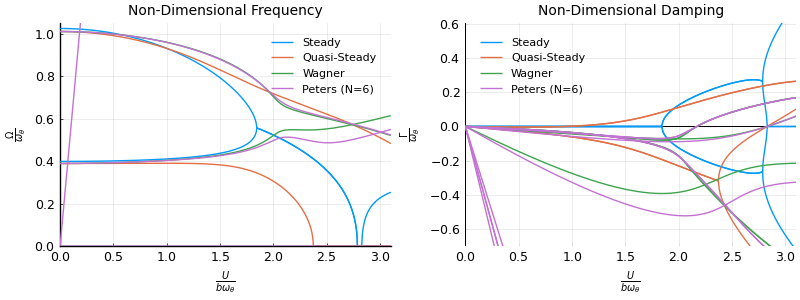

In [2]:
using Plots
pyplot()

sp1 = plot(
    title = "Non-Dimensional Frequency",
    xlim = (0,3.1),
    xtick = 0.0:0.5:3.0,
    xlabel = "\$ \\frac{U}{b \\omega_\\theta} \$",
    ylim = (0, 1.05),
    ytick = 0.0:0.2:1.0,
    ylabel = "\$ \\frac{\\Omega}{\\omega_\\theta} \$",
    titlefontsize = 10,
    guidefontsize = 10,
    legendfontsize = 8,
    tickfontsize = 9,
    foreground_color_legend = nothing,
    background_color_legend = nothing,
    minorgrid=false
    )

sp2 = plot(
    title = "Non-Dimensional Damping",
    xlim = (0,3.1),
    xtick = 0.0:0.5:3.0,
    xlabel = "\$ \\frac{U}{b \\omega_\\theta} \$",
    ylim = (-0.7, 0.605),
    ytick = -0.6:0.2:0.6,
    ylabel = "\$ \\frac{Γ}{\\omega_\\theta} \$",
    framestyle = :zerolines,
    titlefontsize = 10,
    guidefontsize = 10,
    legendfontsize = 8,
    tickfontsize = 9,
    legend = :topleft,
    foreground_color_legend = nothing,
    background_color_legend = nothing,
    minorgrid = false
    )

labels = ["Steady", "Quasi-Steady", "Wagner", "Peters (N=6)"]

for ia = 1:length(models)

    plot!(sp1, V, imag.(λ[ia][1,:])/ωθ,
        label = labels[ia],
        color = ia,
        markersize = 1,
        markerstrokewidth = 0,
        )

    for i = 2:size(λ[ia], 1)
        plot!(sp1, V, imag.(λ[ia][i,:])/ωθ,
            label = "",
            color = ia,
            markersize = 1,
            markerstrokewidth = 0,
            )
    end

    plot!(sp2, V, real.(λ[ia][1,:])/ωθ,
        label = labels[ia],
        color = ia,
        markersize = 1,
        markerstrokewidth = 0,
        )

    for i = 2:size(λ[ia], 1)
        plot!(sp2, V, real.(λ[ia][i,:])/ωθ,
            label = "",
            color = ia,
            markersize = 1,
            markerstrokewidth = 0,
            )
    end
end

p1 = plot(sp1, sp2, layout = (1, 2), size = (800, 300))

Using the `Wagner` or `Peters` aerodynamic models yields a flutter reduced velocity
around 2.2, while the `Steady` and `QuasiSteady` aerodynamic models predict
significantly lower flutter velocities.  The aerodynamic state variables of the
`Wagner` and `Peters` models allows these models to capture the impact of vortex
shedding on the lift and drag of the profile, therefore we can expect these models to
yield more accurate results than the `Steady` and `QuasiSteady` models.

The non-dimensional parameters we use for this example match those used by Hodges and
Pierce in "Introduction to Structural Dynamics and Aeroelasticity".  Hodges and Pierce
performed the analysis using a steady-state model and Peter's finite state model with
six state variables.   The results presented here for the steady-state and Peters'
finite state models match the results presented by Hodges and Pierce in "Introduction
to Structural Dynamics and Aeroelasticity", which provides a verification for our
implementation of these models.  Additionally, since the flutter speed predicted by the
`Wagner` and  `Peters` models match, we can be reasonably confident that the Wagner
unsteady aerodynamic model is also implemented correctly.

---

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*